In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.data
import scipy.misc
import scipy.signal
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import rcParams
rcParams['axes.grid'] = False

import torchvision
from torchvision import models
from torchvision import transforms
from torchvision import datasets

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [0]:
# Question 2 Part a
from torchvision.datasets import FashionMNIST
# loads Fashion-MNIST dataset
data_train_MNIST = FashionMNIST(root = 'HOME/data/Fashion-MNIST/processed/',train=True,download=True)
train_data = data_train_MNIST.train_data.numpy()
train_label = data_train_MNIST.train_labels.numpy()


data_test_MNIST = FashionMNIST(root = 'HOME/data/Fashion-MNIST/processed/',train=False,download=True)
test_data = data_test_MNIST.test_data.numpy()
test_label = data_test_MNIST.test_labels.numpy()

# data parameters
num_train_examples = train_data.shape[0] # 60000 for MNIST fashion
num_test_examples = test_data.shape[0] # 10000 for MNIST fashion
WIDTH, HEIGHT = train_data.shape[1],train_data.shape[2] # 28, 28 for MNIST fashion
num_classes = np.unique(train_label).shape[0] # 10 for MNIST fashion

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
# Dataset Creation Class
TRAIN_MEAN = [0.485,0.456,0.406]
TRAIN_STD = [0.229,0.224,0.225]
train_transform = transforms.Compose([
    transforms.Normalize(TRAIN_MEAN, TRAIN_STD)
])

class MNISTDataset(Dataset):
  """
  for mode 'MNIST':
    input is the data numpy array with size (num_examples,image height, image width) 
    and label numpy array with size (num_examples).

    output is data tensor with size (num_examples, 3 channels, image height, image width)
    and label tensors with size (num_examples)
  """
  def __init__(self, data_all, label_all, mode = 'MNIST', transform=None):
    self.data_all = data_all
    self.label_all = label_all

    self.mode = mode 
    self.transform = transform

  def __len__ (self):
    return self.data_all.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    if self.mode == 'MNIST':
      # only take data example at index idx
      data = self.data_all[idx,:,:] / 255
      # view() adds extra channel to input data
      # repeat() repeats data for 3 channels to fit VGG model 
      data = np.repeat(data.reshape(1,28,28),3,axis=0)
      data = torch.from_numpy(data).float()

      if self.transform:
        data = self.transform(data)

      label = torch.from_numpy(np.array(self.label_all[idx])).float()

    item = {'image': data, 'mask': label}
    return item
    

In [0]:
def experiment_main(num_epoch,learning_rate):
  # experiment cell
  # problem 1a
  # hyperparameters
  learning_rate = learning_rate
  num_epoch =  num_epoch

  num_steps_per_test = 20

  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

  info = []

  # ImageDataset Objects
  train_dataset = MNISTDataset(train_data,train_label,mode='MNIST',transform=train_transform)
  test_dataset = MNISTDataset(test_data,test_label,mode='MNIST',transform=train_transform)

  # dataloader objects for train and test datasets
  dataloader_train = DataLoader(train_dataset, batch_size = train_batch_size, shuffle=True)
  dataloader_test = DataLoader(test_dataset, batch_size = test_batch_size, shuffle=True)


  best_test_err = 1.0
  fig, ax = plt.subplots(3, 1, sharex=True)

  print("Start Training,...lr: ",learning_rate)
  convergence_counter = 0
  for epoch in range(num_epoch):
    ########################### Training #####################################

    dataloader_train_iterator = enumerate(dataloader_train)
    i_batch,item_batch = next(dataloader_train_iterator)
    input_batch = item_batch['image'].cuda()
    label_batch = item_batch['mask'].cuda()
    output_batch = model(input_batch)

    # print('output_batch size',output_batch.size())
    # print(output_batch[0,:])
    # print('input_batch size',input_batch.size(),'label batch size',label_batch.size())
    # print(torch.unique(input_batch[0,:,:]))
    # print(label_batch[:])
    # print('mean', torch.mean(input_batch[0],dim=(1,2)))
    # print('std',torch.std(input_batch[0],dim=(1,2)))

    # Compute loss (and error rate).
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(output_batch, label_batch.long())  

    train_loss = loss.item()

    # resets gradients and does backpropagation to find gradients
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    #scheduler.step()

    # converts tensors to numpy arrays for computation to reduce CUDA memory usage
    output_batch = output_batch.cpu().detach().numpy()
    label_batch = label_batch.cpu().detach().numpy()

    train_err = 1.0 - (np.argmax(output_batch,axis=1) == label_batch).mean()
  

    ########################### test #####################################
    if epoch % num_steps_per_test == 0:
      with torch.no_grad():
        # print("\nEPOCH " +str(epoch+1)+" of "+str(num_epoch)+"\n")
        model.eval()

        dataloader_test_iterator = enumerate(dataloader_test)
        i_batch,item_batch = next(dataloader_test_iterator)
        input_batch = item_batch['image'].cuda()
        label_batch = item_batch['mask'].cuda()

        output_batch = model(input_batch)
        # computes loss using dice loss
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(output_batch, label_batch.long())  
        test_loss = loss.item()

        # converts tensors to numpy arrays for computation to reduce CUDA memory usage
        output_batch = output_batch.cpu().detach().numpy()
        label_batch = label_batch.cpu().detach().numpy()
        
        # computes error rate by comparing predicted class and true class for all batch examples
        test_err = 1.0 - (np.argmax(output_batch,axis=1) == label_batch).mean()

        if test_err < best_test_err:
              best_test_err = test_err
              print('Step {:5d}: Obtained a best test error of {:.3f}.'.format(epoch, best_test_err))
              convergence_counter = 0
        else:
              convergence_counter +=1
              # if convergence_counter > number of test checks
              if convergence_counter > 150:
                print('stopped training on epoch: ', epoch)
                break

        # plotting
        info.append([epoch, train_loss, test_loss, train_err, test_err])
        x, y11, y12, y21, y22 = zip(*info)
        ax[0].plot(x, y11, x, y12)
        ax[0].legend(['Train loss', 'test loss'])
        ax[1].plot(x, y21, x, y22)
        ax[1].legend(['Train err', 'test err'])
        ax[2].plot(x[1:],y21[1:],x[1:],y22[1:])
        ax[2].legend(['Train err skip first iteration','test err skip first iteration'])
  plt.show()
  print('test accuracy :', 1 - best_test_err)
  print(info)

Start Training,...lr:  0.001
Step     0: Obtained a best test error of 0.880.
Step   120: Obtained a best test error of 0.820.
Step   500: Obtained a best test error of 0.780.
stopped training on epoch:  3520


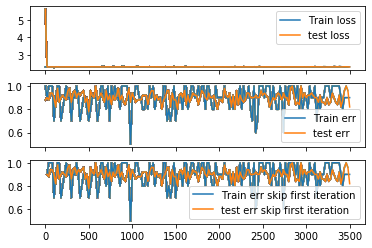

test accuracy : 0.21999999999999997
[[0, 2.3052282333374023, 5.596751689910889, 1.0, 0.88], [20, 2.293205738067627, 2.2965285778045654, 0.9, 0.9], [40, 2.306452512741089, 2.299588441848755, 1.0, 0.88], [60, 2.304210662841797, 2.301750659942627, 1.0, 0.94], [80, 2.3052027225494385, 2.3042216300964355, 1.0, 0.94], [100, 2.273531675338745, 2.3022937774658203, 0.7, 0.9], [120, 2.304298162460327, 2.2989940643310547, 0.9, 0.8200000000000001], [140, 2.3005893230438232, 2.3095169067382812, 1.0, 0.98], [160, 2.3032097816467285, 2.2993974685668945, 1.0, 0.86], [180, 2.2985081672668457, 2.3032846450805664, 0.7, 0.9], [200, 2.303746461868286, 2.3028409481048584, 0.8, 0.92], [220, 2.298518419265747, 2.3039209842681885, 0.9, 0.9], [240, 2.3048949241638184, 2.3025853633880615, 1.0, 0.88], [260, 2.303907871246338, 2.3045248985290527, 0.9, 0.96], [280, 2.305443525314331, 2.3049538135528564, 0.9, 0.98], [300, 2.298128366470337, 2.3015341758728027, 0.7, 0.86], [320, 2.30088472366333, 2.3057165145874023, 

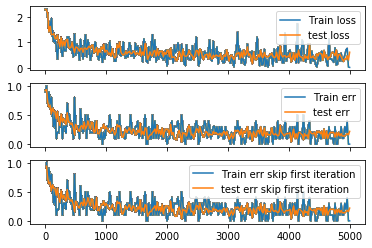

test accuracy : 0.96
[[0, 2.3062448501586914, 2.302856206893921, 0.9, 0.92], [20, 2.3092799186706543, 2.2788965702056885, 1.0, 0.94], [40, 1.987103819847107, 2.108171224594116, 0.7, 0.72], [60, 1.6577228307724, 1.4189043045043945, 0.9, 0.64], [80, 1.6563533544540405, 1.630604863166809, 0.7, 0.6599999999999999], [100, 1.9374020099639893, 1.316471815109253, 0.8, 0.52], [120, 1.2599315643310547, 1.3060837984085083, 0.5, 0.62], [140, 1.0273607969284058, 1.3444645404815674, 0.30000000000000004, 0.56], [160, 1.0838873386383057, 1.173926830291748, 0.5, 0.56], [180, 0.8793995976448059, 1.1513190269470215, 0.09999999999999998, 0.43999999999999995], [200, 0.3416081666946411, 1.2823659181594849, 0.19999999999999996, 0.56], [220, 0.9692988395690918, 1.0188648700714111, 0.19999999999999996, 0.4], [240, 0.9991048574447632, 0.8230802416801453, 0.4, 0.31999999999999995], [260, 0.7516269683837891, 1.188347339630127, 0.5, 0.52], [280, 0.45147091150283813, 0.8538792133331299, 0.09999999999999998, 0.38], 

In [0]:
# global variables
torch.manual_seed(11)
train_batch_size = 10
test_batch_size = 50
num_epoch = 5001
learning_rate_list = [.001,.0001]

for k in range(len(learning_rate_list)):
  model = torchvision.models.vgg16(pretrained=False, progress=True)
  # changes model to fit MNIST data
  # specifically deleted last maxpool in model.features and changed last layer output from 1000 to output num_classes 
  model.features = nn.Sequential(*list(model.features.children())[:-1])
  model.classifier[6] = nn.Linear(4096,10)
  model.cuda()

  experiment_main(num_epoch=num_epoch,learning_rate = learning_rate_list[k])

Start Training,...lr:  0.001
Step     0: Obtained a best test error of 0.720.
Step    20: Obtained a best test error of 0.260.
Step    60: Obtained a best test error of 0.220.
Step   200: Obtained a best test error of 0.140.
Step   860: Obtained a best test error of 0.080.
stopped training on epoch:  3880


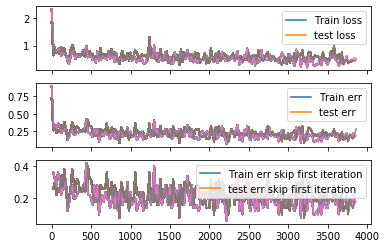

test accuracy : 0.92
[[0, 2.3033242225646973, 1.8516849279403687, 0.9, 0.72], [20, 1.026269793510437, 0.651847243309021, 0.36, 0.26], [40, 0.9073137640953064, 0.9241624474525452, 0.31999999999999995, 0.30000000000000004], [60, 0.7351813316345215, 0.7328725457191467, 0.28, 0.21999999999999997], [80, 0.8407170176506042, 0.7584213018417358, 0.36, 0.26], [100, 0.9153538346290588, 0.6933252215385437, 0.31999999999999995, 0.24], [120, 0.6510037779808044, 0.937852680683136, 0.21999999999999997, 0.33999999999999997], [140, 0.7401032447814941, 0.767935037612915, 0.26, 0.28], [160, 0.7051299214363098, 0.9031227827072144, 0.26, 0.38], [180, 0.6975457072257996, 0.6466590762138367, 0.31999999999999995, 0.28], [200, 0.46556586027145386, 0.6276060342788696, 0.12, 0.14], [220, 0.3539181053638458, 0.584040105342865, 0.16000000000000003, 0.19999999999999996], [240, 0.6122918128967285, 0.8242008090019226, 0.24, 0.26], [260, 0.8042982220649719, 1.0316033363342285, 0.28, 0.38], [280, 0.7589254975318909, 0.

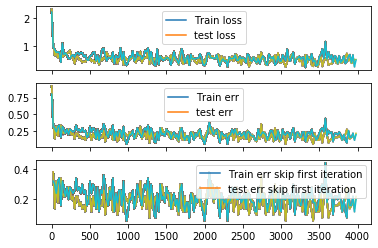

test accuracy : 0.94
[[0, 2.331662654876709, 2.2287068367004395, 0.92, 0.8], [20, 1.094254493713379, 0.9706137776374817, 0.38, 0.31999999999999995], [40, 0.6553826332092285, 0.8763524889945984, 0.14, 0.30000000000000004], [60, 0.8000783324241638, 0.7704939842224121, 0.31999999999999995, 0.24], [80, 0.5703719854354858, 0.7889352440834045, 0.18000000000000005, 0.31999999999999995], [100, 0.7052168250083923, 0.7724865078926086, 0.30000000000000004, 0.33999999999999997], [120, 0.7419406771659851, 0.41527560353279114, 0.33999999999999997, 0.16000000000000003], [140, 0.6085854768753052, 1.1072611808776855, 0.24, 0.31999999999999995], [160, 0.6649848222732544, 0.7036064863204956, 0.21999999999999997, 0.28], [180, 0.7243578433990479, 0.7460665106773376, 0.24, 0.21999999999999997], [200, 0.7285586595535278, 0.6701651811599731, 0.26, 0.28], [220, 0.7663725018501282, 0.5462782979011536, 0.28, 0.19999999999999996], [240, 0.8436580896377563, 0.5429731607437134, 0.26, 0.28], [260, 0.5842352509498596

In [0]:
# Question 2 part b

# global variables
train_batch_size = 50
test_batch_size = 50
num_epoch = 5001
learning_rate_list = [.001,.0001]

for k in range(len(learning_rate_list)):
  model = torchvision.models.vgg16(pretrained=False, progress=True)

  state_dict = torch.load("vgg16-397923af.pth")
  model.load_state_dict(state_dict)
  model.features = nn.Sequential(*list(model.features.children())[:-1])
  model.classifier[6] = nn.Linear(4096,10)

  # test code for freezing
  # freezes all Conv2d layers
  for child in model.features:
    if isinstance(child, nn.Conv2d):
      for param in child.parameters():
        param.requires_grad = False
  # freezes all linear layers except for last
  count = 0
  for child in model.classifier:
    if isinstance(child, nn.Linear):
      count += 1
      if count < 2:
        for param in child.parameters():
          param.requires_grad = False 
      if count > 2:
        for param in child.parameters():
          param.requires_grad = True
  model.cuda()

  experiment_main(num_epoch=num_epoch,learning_rate = learning_rate_list[k])

Start Training,...lr:  0.001
Step     0: Obtained a best test error of 0.760.
Step    20: Obtained a best test error of 0.360.
Step    60: Obtained a best test error of 0.320.
Step    80: Obtained a best test error of 0.300.
Step   100: Obtained a best test error of 0.200.
Step   340: Obtained a best test error of 0.140.
Step   420: Obtained a best test error of 0.120.
Step  1220: Obtained a best test error of 0.060.
stopped training on epoch:  4240


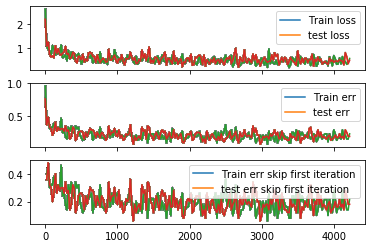

test accuracy : 0.94
[[0, 2.592130422592163, 2.1821675300598145, 0.96, 0.76], [20, 1.0748538970947266, 1.0815589427947998, 0.4, 0.36], [40, 0.9531311988830566, 1.250625729560852, 0.45999999999999996, 0.48], [60, 0.8996577262878418, 0.7716445922851562, 0.30000000000000004, 0.31999999999999995], [80, 0.7185347676277161, 0.6440595388412476, 0.31999999999999995, 0.30000000000000004], [100, 1.1036784648895264, 0.6854195594787598, 0.31999999999999995, 0.19999999999999996], [120, 0.9721118807792664, 0.6212419867515564, 0.38, 0.26], [140, 0.7274919748306274, 1.1005864143371582, 0.30000000000000004, 0.4], [160, 0.8164623975753784, 0.7896488308906555, 0.31999999999999995, 0.26], [180, 0.7877635359764099, 0.9765028953552246, 0.31999999999999995, 0.31999999999999995], [200, 0.8004257082939148, 0.7628604769706726, 0.28, 0.28], [220, 1.1313626766204834, 0.7158138751983643, 0.45999999999999996, 0.30000000000000004], [240, 0.6180633902549744, 0.7990501523017883, 0.24, 0.30000000000000004], [260, 0.657

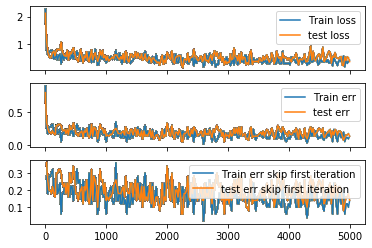

test accuracy : 0.94
[[0, 2.2604966163635254, 2.1167845726013184, 0.9, 0.8], [20, 0.8297378420829773, 1.1610805988311768, 0.28, 0.36], [40, 0.6305311918258667, 0.7231088876724243, 0.18000000000000005, 0.26], [60, 0.7148695588111877, 0.572666585445404, 0.28, 0.19999999999999996], [80, 0.770064115524292, 0.5051546692848206, 0.28, 0.19999999999999996], [100, 0.7825611233711243, 0.5682182908058167, 0.30000000000000004, 0.18000000000000005], [120, 0.7542057633399963, 0.7065574526786804, 0.31999999999999995, 0.21999999999999997], [140, 0.46970465779304504, 0.7528060078620911, 0.21999999999999997, 0.18000000000000005], [160, 0.5085433721542358, 0.5896896719932556, 0.18000000000000005, 0.16000000000000003], [180, 0.6442394256591797, 0.7661644816398621, 0.30000000000000004, 0.30000000000000004], [200, 0.4424499273300171, 0.8230313658714294, 0.18000000000000005, 0.30000000000000004], [220, 0.6002773642539978, 0.822594404220581, 0.19999999999999996, 0.31999999999999995], [240, 0.6394153833389282,

In [0]:
# Question 2 part c

# unfreezing all Linear Layers

# global variables
train_batch_size = 50
test_batch_size = 50
num_epoch = 5001
learning_rate_list = [.001,.0001]

for k in range(len(learning_rate_list)):
  model = torchvision.models.vgg16(pretrained=False, progress=True)

  state_dict = torch.load("vgg16-397923af.pth")
  model.load_state_dict(state_dict)
  model.features = nn.Sequential(*list(model.features.children())[:-1])
  model.classifier[6] = nn.Linear(4096,10)

  # test code for freezing
  # freezes all Conv2d layers
  for child in model.features:
    if isinstance(child, nn.Conv2d):
      for param in child.parameters():
        param.requires_grad = False
  # freezes all linear layers except for last
  count = 0
  for child in model.classifier:
    if isinstance(child, nn.Linear):
        for param in child.parameters():
          param.requires_grad = True
  model.cuda()  

  experiment_main(num_epoch=num_epoch,learning_rate = learning_rate_list[k])

In [0]:
# # input, output, label batch size debug commands
# print('output_batch size',output_batch.size())
# print(output_batch[0,:])
# print('input_batch size',input_batch.size(),'label batch size',label_batch.size())
# print(torch.unique(input_batch[0,:,:]))
# print(label_batch[:])


# testing normalize function from transforms
# normalize = transforms.Normalize(TRAIN_MEAN, TRAIN_STD)

# test = torch.zeros(3,4,4)
# test[0,:,:] = torch.FloatTensor([[.2,.3,.4,.5],[.3,.4,.5,.6],[.2,.3,.4,.5],[.2,.3,.4,.5]])
# test[1,:,:] = torch.FloatTensor([[.2,.3,.4,.5],[.2,.3,.4,.5],[.2,.3,.4,.5],[.2,.3,.4,.5]])
# test[2,:,:] = torch.FloatTensor([[.2,.3,.4,.5],[.2,.3,.4,.5],[.2,.3,.4,.8],[.2,.3,.4,.5]])

# normalize(test)

# print(torch.mean(test,dim=(1,2)))
# print(torch.std(test,dim=(1,2)))

# test code for freezing
# # freezes all Conv2d layers
# for child in model.features:
#   if isinstance(child, nn.Conv2d):
#     for param in child.parameters():
#       param.requires_grad = False
# # freezes all linear layers except for last
# count = 0
# for child in model.classifier:
#    if isinstance(child, nn.Linear):
#      if count < 2:
#        for param in child.parameters():
#          param.requires_grad = False 